In [13]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
! git clone https://www.github.com/eyv7jz/PCA/

Cloning into 'PCA'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 49 (delta 7), reused 3 (delta 3), pack-reused 35 (from 1)
Receiving objects: 100% (49/49), 2.47 MiB | 6.49 MiB/s, done.
Resolving deltas: 100% (12/12), done.


## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [4]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
df

,index,Unnamed: 0,Email Text,Email Type
0,0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...,...
18629,18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18630,18646,18647,request submitted : access request for anita ....,Safe Email
18631,18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18632,18648,18649,press clippings - letter on californian utilit...,Safe Email


In [5]:
tokens = df['Email Text'].str.split()
tokens

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."
...,...
18629,"[date, a, lonely, housewife, always, wanted, t..."
18630,"[request, submitted, :, access, request, for, ..."
18631,"[re, :, important, -, prc, mtg, hi, dorn, &, j..."
18632,"[press, clippings, -, letter, on, californian,..."


To clean the data I would do things like check for missing entries or duplicates and remove common words (e.g. and, the, a, etc.). Then, I would one-hot-encode the emails' tokens to use as potential predictors. Next, I would run different predictive models like linear regressions on the one-hot-encoded tokens and pricipal components.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [12]:
with open('PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: >

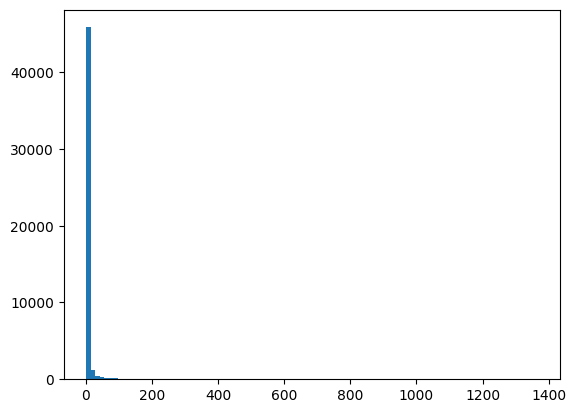

In [17]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

In [18]:
gdf['count'].describe()

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


Most tokens only appear once with a very few appearing multiple times. There is a really long tail in this histogram that isn't really visible, characteristic of natural language data as some words are used more commonly than others.

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [22]:
df = pd.read_parquet('PCA/05_PCA/Phishing_clean.parquet')

In [23]:
# 1. Perform an 80/20 train-test split of the data.
y = df['Email Type']
X = df.drop('Email Type',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

In [29]:
# 2. Run a regression of  𝑦  on the one-hot-encoded emails. What is the  𝑅2  on the test set? On the training set?
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test = lm_0.predict(X_test)
y_hat_train = lm_0.predict(X_train)
print('Rsq: ', r2_score(y_hat_test,y_test))
print('Rsq: ', r2_score(y_hat_train,y_train))

Rsq:  -0.00026838432670373
Rsq:  0.6210107280960204


In [37]:
# 3. What words have the largest coefficients in absolute value and most strongly influence predictions?
q3 = pd.DataFrame({'Variable':lm_0.feature_names_in_, 'Coefficient':lm_0.coef_})
q3['Abs_Coefficient'] = q3['Coefficient'].abs()
largest_coefficients = q3.sort_values(by='Abs_Coefficient', ascending=False)
print(largest_coefficients)

        Variable   Coefficient  Abs_Coefficient
710         1997 -1.415784e+13     1.415784e+13
421         1995  1.158467e+13     1.158467e+13
1133         19, -1.025713e+13     1.025713e+13
340         2005 -9.773947e+12     9.773947e+12
1146       -0400 -8.062341e+12     8.062341e+12
...          ...           ...              ...
1399       union  2.822876e-04     2.822876e-04
565         east -2.746582e-04     2.746582e-04
2268     ravages -1.068115e-04     1.068115e-04
457          due -6.484985e-05     6.484985e-05
2709  leadership -6.103516e-05     6.103516e-05

[2711 rows x 3 columns]


Mostly numbers have the largest coefficients in absolute value, so they have the most influence on the model.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

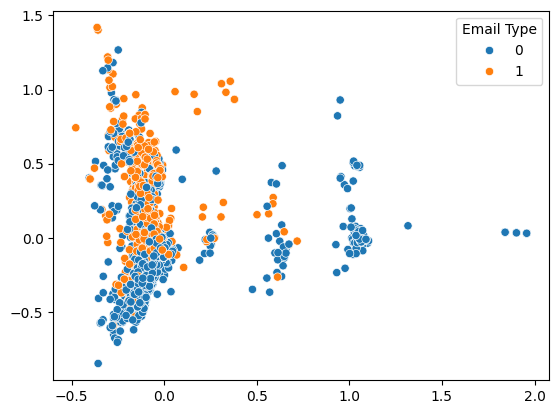

In [39]:
pca = PCA(n_components = 2).fit(X_train)
Z_test = pca.transform(X_test)
Z_train = pca.transform(X_train)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The key shows orange dots being phishing emails. They tend to have a high second component and a low first component. The phishing emails and the non-phishing emails are not that separated unforunately.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [42]:
pca_2 = PCA(n_components = 2610).fit(X_train)
Z_test_2 = pca_2.transform(X_test)
Z_train_2 = pca_2.transform(X_train)
lm_1 = LinearRegression().fit(Z_train_2,y_train)
y_hat_test_2 = lm_1.predict(Z_test_2)
y_hat_train_2 = lm_1.predict(Z_train_2)
print('Rsq: ', r2_score(y_hat_test_2,y_test))
print('Rsq: ', r2_score(y_hat_train_2,y_train))

Rsq:  0.5873905973217184
Rsq:  0.692897536096375


This model performs better than the linear regression model because the R squared is 0.58739 as compared to -0.00026 and the test R squared is closer to the training R squared as compared to the linear regression values.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Original features in high-dimensional data often have strong correlations, which can lead to multicollinearity and unstable regression coefficients. Principal components are uncorrelated (orthogonal), eliminating this issue. Principal components reduce the number of features by filtering out the less significant components while retaining the most important variance in the data. This makes the model more efficient and computationally faster, especially for high-dimensional datasets. Principal components are linear combinations of the original features, which makes them abstract and harder to interpret. You lose the ability to directly link regression coefficients to specific features in the original dataset.